In [63]:
import numpy as np
import networkx as nx
from tqdm import tqdm
import matplotlib.pyplot as plt
import json

rng = np.random.default_rng(42)

# Example non-uniform number of individuals per type
num_individuals_per_type = [36000, 24000, 8000, 12000, 10000, 1600, 3600, 800, 1600]
num_types = len(num_individuals_per_type)

# Initialize positions randomly
def initialize_positions_randomly(num_individuals_per_type, x_max, y_max, z_max):
    positions = []
    for num_individuals in num_individuals_per_type:
        for _ in range(num_individuals):
            position = [rng.integers(0, x_max), rng.integers(0, y_max), rng.integers(0, z_max)]
            positions.append(position)
    return np.array(positions, dtype='float64')

# Calculate forces based on the networkx graph within range r
def calculate_forces_complex(positions, graph, num_individuals_per_type, rs, D_e=1.0, alpha=1.0, sigma=1.0):
    forces = np.zeros_like(positions)
    
    # Precompute the start index for each type
    start_index = np.zeros(num_types, dtype=int)
    start_index[1:] = np.cumsum(num_individuals_per_type[:-1])
    
    # Lennard-Jones force strength function
    def lennard_jones_force(distance, epsilon):
        force_magnitude = 48 * epsilon * ((sigma / distance)**13 - 0.5 * (sigma / distance)**7)
        return force_magnitude
    
    # Morse potential force strength function
    def morse_force(distance, D_e, alpha, r_e):
        exp_term = np.exp(-alpha * (distance - r_e))
        force_magnitude = 2 * alpha * D_e * exp_term * (1 - exp_term)
        return force_magnitude
    
    # Loop over each type
    for type_i in range(num_types):
        num_i = num_individuals_per_type[type_i]
        nghs = graph.neighbors(type_i)
        node = graph[type_i]
        r = rs[type_i]
        
        # Loop over each individual in type_i
        for j in range(start_index[type_i], start_index[type_i] + num_i):
            pos_j = positions[j]
            
            # Loop over neighboring types
            for type_j in nghs:
                weight = node[type_j]['weight']
                num_j = num_individuals_per_type[type_j]
                
                # Determine interaction type based on weight
                if weight < 0:
                    interaction = 'repulsion'
                    epsilon = -weight  # Strength of repulsion
                else:
                    interaction = 'attraction'
                    epsilon = weight  # Strength of attraction
                    r_e = sigma  # Equilibrium distance for Morse potential
                
                # Loop over individuals in type_j
                for k in range(start_index[type_j], start_index[type_j] + num_j):
                    if j == k:
                        continue  # Avoid self-interaction
                    
                    pos_k = positions[k]
                    distance_vector = pos_k - pos_j
                    distance = np.linalg.norm(distance_vector)
                    
                    if distance <= r:
                        if interaction == 'repulsion':
                            force_magnitude = lennard_jones_force(distance, epsilon)
                        else:
                            force_magnitude = morse_force(distance, D_e, alpha, r_e)
                        
                        force_vector = force_magnitude * (distance_vector / distance) if distance != 0 else 0
                        
                        forces[j] += force_vector
                        forces[k] -= force_vector
    
    return forces

# Calculate forces based on the networkx graph within range r
def calculate_forces_simple(positions, graph, num_individuals_per_type, rs):
    forces = np.zeros_like(positions)
    
    # Precompute the start index for each type
    start_index = np.zeros(num_types, dtype=int)
    start_index[1:] = np.cumsum(num_individuals_per_type[:-1])
    
    # Loop over each type
    for type_i in range(num_types):
        num_i = num_individuals_per_type[type_i]
        nghs = graph.neighbors(type_i)
        node = graph[type_i]
        r_i = rs[type_i]
        
        # Loop over each individual in type_i
        for j in range(start_index[type_i], start_index[type_i] + num_i):
            pos_j = positions[j]
            
            # Loop over neighboring types
            for type_j in nghs:
                weight = node[type_j]['weight'] * 4
                r_j = rs[type_j]
                num_j = num_individuals_per_type[type_j]
                
                # Loop over individuals in type_j
                for k in range(start_index[type_j], start_index[type_j] + num_j):
                    if j == k:
                        continue  # Avoid self-interaction
                    
                    pos_k = positions[k]
                    distance_vector = pos_k - pos_j
                    distance = np.linalg.norm(distance_vector)
                    
                    if distance <= max(r_i, r_j):  # Use the maximum of the two ranges
                        force_magnitude = weight / (distance ** 2)
                        force_vector = force_magnitude * (distance_vector / distance) if distance != 0 else 0
                        
                        forces[j] += force_vector
                        forces[k] -= force_vector
    
    return forces

In [64]:
# Constants
x_max = 200  # Define the bounds of the 3D space
y_max = 200
z_max = 25
damping_factor = 500  # Damping factor to stabilize the simulation
rs = [1, 1, 3, 3, 3, 4, 5, 6, 6]
iterations = 1000

#co_occ_network = '{"directed": false, "multigraph": false, "graph": {}, "nodes": [{"id": 0}, {"id": 1}, {"id": 2}, {"id": 3}, {"id": 4}, {"id": 5}, {"id": 6}, {"id": 7}, {"id": 8}], "links": [{"weight": 0.5826312884833548, "source": 0, "target": 3}, {"weight": 0.6148356427539814, "source": 0, "target": 4}, {"weight": 0.7306576990838498, "source": 1, "target": 2}, {"weight": 0.9003900420385831, "source": 1, "target": 5}, {"weight": -0.638579754693958, "source": 1, "target": 7}, {"weight": -0.27796656418881527, "source": 2, "target": 7}, {"weight": 0.46123412849139406, "source": 3, "target": 4}, {"weight": 0.6068144174853789, "source": 5, "target": 8}]}'
#co_occ_network = '{"directed": false, "multigraph": false, "graph": {}, "nodes": [{"id": 0}, {"id": 1}, {"id": 2}, {"id": 3}, {"id": 4}, {"id": 5}, {"id": 6}, {"id": 7}, {"id": 8}], "links": [{"weight": 0.5826312884833548, "source": 0, "target": 2}, {"weight": 0.6148356427539814, "source": 0, "target": 8}, {"weight": 0.7306576990838498, "source": 2, "target": 4}, {"weight": 0.9003900420385831, "source": 2, "target": 8}, {"weight": -0.638579754693958, "source": 3, "target": 6}, {"weight": -0.27796656418881527, "source": 3, "target": 8}, {"weight": 0.46123412849139406, "source": 4, "target": 5}, {"weight": 0.6068144174853789, "source": 7, "target": 8}]}'
#co_occ_network = '{"directed": false, "multigraph": false, "graph": {}, "nodes": [{"id": 0}, {"id": 1}, {"id": 2}, {"id": 3}, {"id": 4}, {"id": 5}, {"id": 6}, {"id": 7}, {"id": 8}], "links": [{"weight": 0.5826312884833548, "source": 1, "target": 4}, {"weight": 0.6148356427539814, "source": 1, "target": 5}, {"weight": 0.7306576990838498, "source": 1, "target": 6}, {"weight": 0.9003900420385831, "source": 2, "target": 5}, {"weight": -0.638579754693958, "source": 2, "target": 6}, {"weight": -0.27796656418881527, "source": 2, "target": 8}, {"weight": 0.46123412849139406, "source": 3, "target": 5}, {"weight": 0.6068144174853789, "source": 4, "target": 5}, {"weight": 0.5112680070896285, "source": 4, "target": 6}, {"weight": 0.42525572507758125, "source": 4, "target": 7}, {"weight": 0.4601658168250095, "source": 4, "target": 8}, {"weight": 0.4943223393958548, "source": 5, "target": 6}]}'
#co_occ_network = '{"directed": false, "multigraph": false, "graph": {}, "nodes": [{"id": 0}, {"id": 1}, {"id": 2}, {"id": 3}, {"id": 4}, {"id": 5}, {"id": 6}, {"id": 7}, {"id": 8}], "links": [{"weight": 0.5826312884833548, "source": 0, "target": 1}, {"weight": 0.6148356427539814, "source": 0, "target": 3}, {"weight": 0.7306576990838498, "source": 0, "target": 5}, {"weight": 0.9003900420385831, "source": 0, "target": 8}, {"weight": -0.638579754693958, "source": 1, "target": 3}, {"weight": -0.27796656418881527, "source": 1, "target": 5}, {"weight": 0.46123412849139406, "source": 1, "target": 6}, {"weight": 0.6068144174853789, "source": 3, "target": 7}, {"weight": 0.5112680070896285, "source": 3, "target": 8}, {"weight": 0.42525572507758125, "source": 4, "target": 5}, {"weight": 0.4601658168250095, "source": 4, "target": 6}, {"weight": 0.4943223393958548, "source": 4, "target": 7}, {"weight": -0.14671525430854027, "source": 4, "target": 8}]}'
#co_occ_network = '{"directed": false, "multigraph": false, "graph": {}, "nodes": [{"id": 0}, {"id": 1}, {"id": 2}, {"id": 3}, {"id": 4}, {"id": 5}, {"id": 6}, {"id": 7}, {"id": 8}], "links": [{"weight": 0.5826312884833548, "source": 0, "target": 1}, {"weight": 0.6148356427539814, "source": 0, "target": 3}, {"weight": 0.7306576990838498, "source": 0, "target": 4}, {"weight": 0.9003900420385831, "source": 0, "target": 6}, {"weight": -0.638579754693958, "source": 0, "target": 7}, {"weight": -0.27796656418881527, "source": 1, "target": 3}, {"weight": 0.46123412849139406, "source": 1, "target": 4}, {"weight": 0.6068144174853789, "source": 1, "target": 6}, {"weight": 0.5112680070896285, "source": 1, "target": 7}, {"weight": 0.42525572507758125, "source": 1, "target": 8}, {"weight": 0.4601658168250095, "source": 2, "target": 5}, {"weight": 0.4943223393958548, "source": 2, "target": 6}, {"weight": -0.14671525430854027, "source": 2, "target": 8}, {"weight": -0.4038872117981791, "source": 3, "target": 4}, {"weight": 0.5176903249517476, "source": 3, "target": 6}, {"weight": 0.7534244447856359, "source": 3, "target": 7}, {"weight": 0.5244768288592718, "source": 4, "target": 7}, {"weight": 0.7363358287149884, "source": 4, "target": 8}, {"weight": 0.631262017598583, "source": 5, "target": 6}, {"weight": 0.13566419265027413, "source": 5, "target": 8}, {"weight": 0.7444351489453024, "source": 6, "target": 7}, {"weight": -0.4320948133020824, "source": 7, "target": 8}]}'
#co_occ_network = '{"directed": false, "multigraph": false, "graph": {}, "nodes": [{"id": 0}, {"id": 1}, {"id": 2}, {"id": 3}, {"id": 4}, {"id": 5}, {"id": 6}, {"id": 7}, {"id": 8}], "links": [{"weight": 0.5826312884833548, "source": 0, "target": 1}, {"weight": 0.6148356427539814, "source": 0, "target": 3}, {"weight": 0.7306576990838498, "source": 0, "target": 4}, {"weight": 0.9003900420385831, "source": 0, "target": 6}, {"weight": -0.638579754693958, "source": 0, "target": 7}, {"weight": -0.27796656418881527, "source": 0, "target": 8}, {"weight": 0.46123412849139406, "source": 1, "target": 2}, {"weight": 0.6068144174853789, "source": 1, "target": 4}, {"weight": 0.5112680070896285, "source": 1, "target": 5}, {"weight": 0.42525572507758125, "source": 1, "target": 6}, {"weight": 0.4601658168250095, "source": 1, "target": 7}, {"weight": 0.4943223393958548, "source": 2, "target": 4}, {"weight": -0.14671525430854027, "source": 2, "target": 5}, {"weight": -0.4038872117981791, "source": 3, "target": 4}, {"weight": 0.5176903249517476, "source": 3, "target": 5}, {"weight": 0.7534244447856359, "source": 3, "target": 6}, {"weight": 0.5244768288592718, "source": 3, "target": 8}, {"weight": 0.7363358287149884, "source": 4, "target": 7}, {"weight": 0.631262017598583, "source": 4, "target": 8}, {"weight": 0.13566419265027413, "source": 5, "target": 7}, {"weight": 0.7444351489453024, "source": 5, "target": 8}, {"weight": -0.4320948133020824, "source": 6, "target": 8}, {"weight": -0.581091373256546, "source": 7, "target": 8}]}'
co_occ_network = '{"directed": false, "multigraph": false, "graph": {}, "nodes": [{"id": 0}, {"id": 1}, {"id": 2}, {"id": 3}, {"id": 4}, {"id": 5}, {"id": 6}, {"id": 7}, {"id": 8}], "links": [{"weight": 0.5826312884833548, "source": 0, "target": 5}, {"weight": 0.6148356427539814, "source": 0, "target": 8}, {"weight": 0.7306576990838498, "source": 1, "target": 3}, {"weight": 0.9003900420385831, "source": 1, "target": 4}, {"weight": -0.638579754693958, "source": 1, "target": 6}, {"weight": -0.27796656418881527, "source": 2, "target": 4}, {"weight": 0.46123412849139406, "source": 2, "target": 7}, {"weight": 0.6068144174853789, "source": 2, "target": 8}, {"weight": 0.5112680070896285, "source": 3, "target": 4}, {"weight": 0.42525572507758125, "source": 3, "target": 6}, {"weight": 0.4601658168250095, "source": 3, "target": 7}, {"weight": 0.4943223393958548, "source": 3, "target": 8}, {"weight": -0.14671525430854027, "source": 4, "target": 5}, {"weight": -0.4038872117981791, "source": 4, "target": 6}, {"weight": 0.5176903249517476, "source": 5, "target": 7}, {"weight": 0.7534244447856359, "source": 5, "target": 8}]}'

# Initialize positions
positions = initialize_positions_randomly(num_individuals_per_type, x_max, y_max, z_max)
np.save('init_pos.npy', positions)

# Create a networkx graph
G = nx.node_link_graph(json.loads(co_occ_network))

# Update positions based on forces within range r
for iteration in tqdm(range(iterations)):
    #forces = calculate_forces_complex(positions, G, num_individuals_per_type, rs)
    forces = calculate_forces_simple(positions, G, num_individuals_per_type, rs)
    positions += forces #*  damping_factor

# Round positions to the nearest integer
positions = np.round(positions).astype(int) 

# Ensure positions stay within bounds
positions[:, 0] = np.clip(positions[:, 0], 0, x_max - 1)
positions[:, 1] = np.clip(positions[:, 1], 0, y_max - 1)
positions[:, 2] = np.clip(positions[:, 2], 0, z_max - 1)

#save
np.save('resulting_pos.npy', positions)

100%|██████████| 1000/1000 [25:43<00:00,  1.54s/it] 


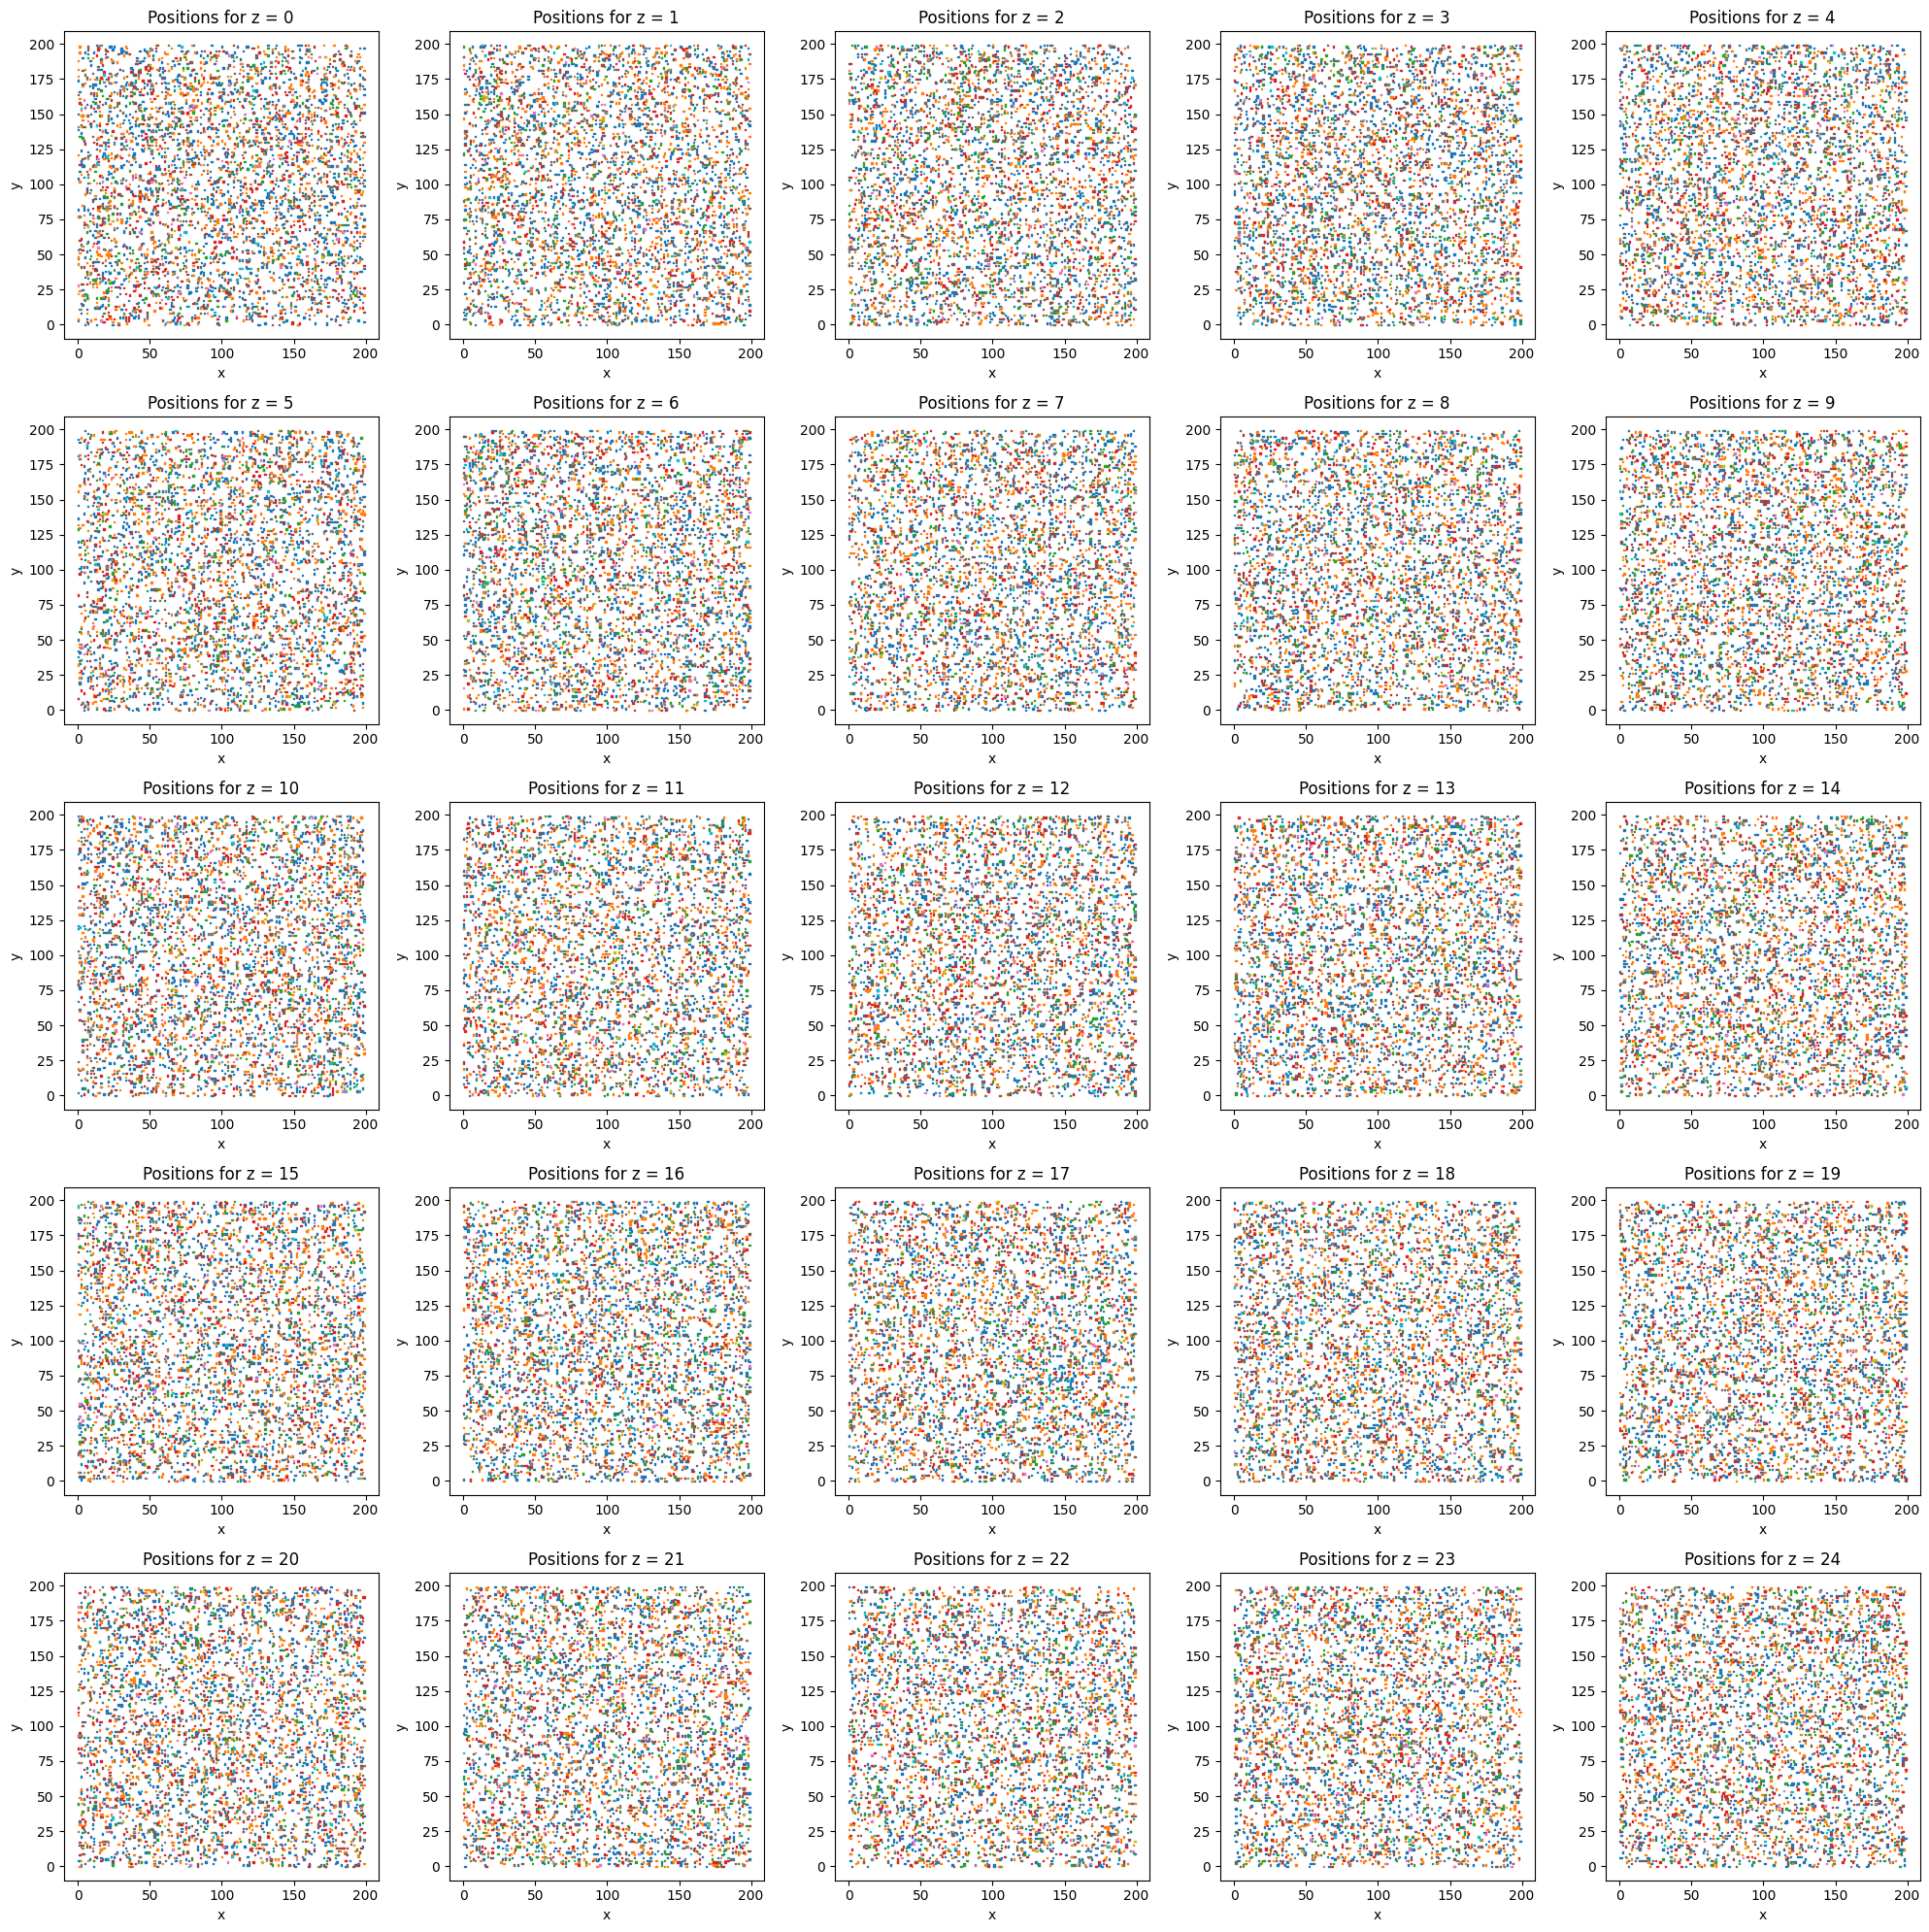

In [65]:
positions = np.load('init_pos.npy')

# Create a list of colors for each type
colors = plt.colormaps['tab10']

# Determine the type of each individual based on their index
types = []
start_index = np.zeros(num_types, dtype=int)
start_index[1:] = np.cumsum(num_individuals_per_type[:-1])
for i in range(num_types):
    types.extend([i] * num_individuals_per_type[i])
types = np.array(types)

z_range = range(z_max)

fig, axes = plt.subplots(5, 5, figsize=(20, 20))
axes = axes.flatten()

for i, z in enumerate(z_range):
    ax = axes[i]
    mask = positions[:, 2] == z
    ax.scatter(positions[mask, 0], positions[mask, 1], c=types[mask], cmap=colors, s=1, marker='s')
    ax.set_title(f'Positions for z = {z}')
    ax.set_xlabel('x')
    ax.set_ylabel('y')

plt.tight_layout()
plt.show()

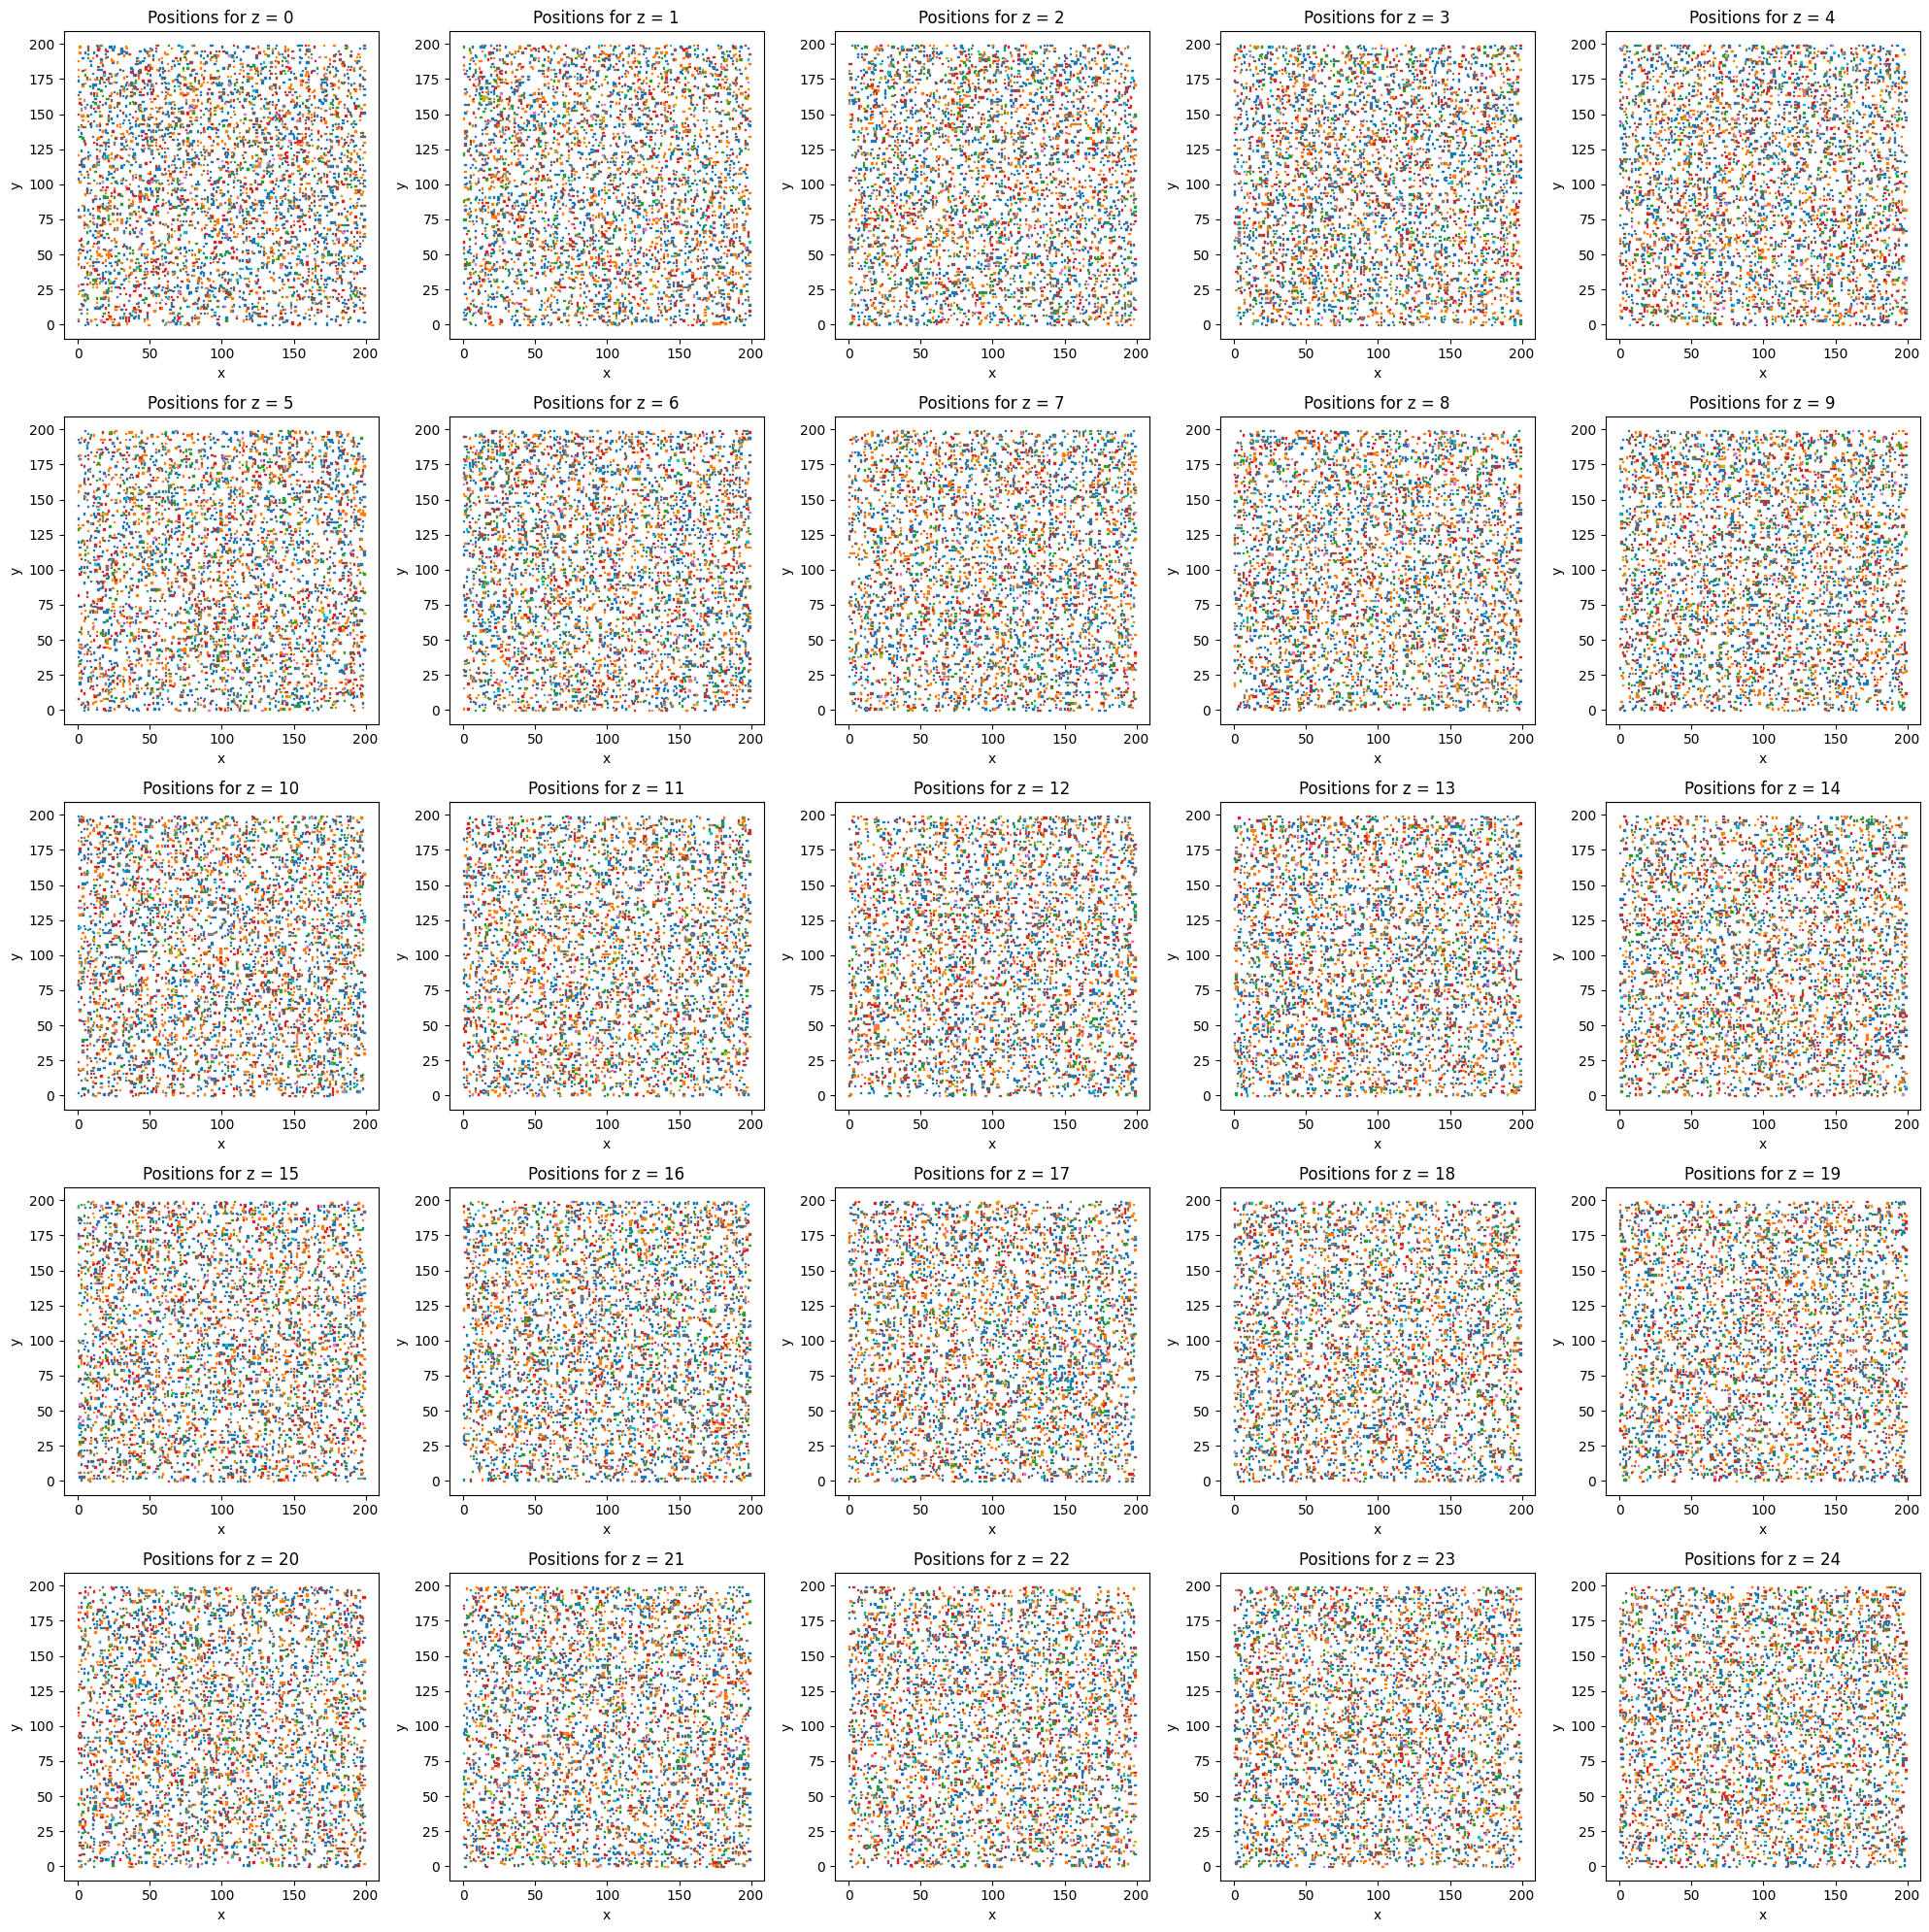

In [66]:
positions = np.load('resulting_pos.npy')
# Create a list of colors for each type
colors = plt.colormaps['tab10']

# Determine the type of each individual based on their index
types = []
start_index = np.zeros(num_types, dtype=int)
start_index[1:] = np.cumsum(num_individuals_per_type[:-1])
for i in range(num_types):
    types.extend([i] * num_individuals_per_type[i])
types = np.array(types)

z_range = range(z_max)

fig, axes = plt.subplots(5, 5, figsize=(20, 20))
axes = axes.flatten()

for i, z in enumerate(z_range):
    ax = axes[i]
    mask = positions[:, 2] == z
    ax.scatter(positions[mask, 0], positions[mask, 1], c=types[mask], cmap=colors, s=1, marker='s')
    ax.set_title(f'Positions for z = {z}')
    ax.set_xlabel('x')
    ax.set_ylabel('y')

plt.tight_layout()
plt.show()